In [2]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

In [3]:
class LowLightSRDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform_noisy=None, transform_clean=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform_noisy = transform_noisy
        self.transform_clean = transform_clean
        self.images = sorted(os.listdir(noisy_dir))  # full noisy filenames like "val_00001.png"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        noisy_filename = self.images[idx]  # e.g. val_00001.png
        img_id = noisy_filename.split("_")[-1]  # get 00001.png
        clean_filename = f"gt_{img_id}"        # build gt_00001.png

        noisy_path = os.path.join(self.noisy_dir, noisy_filename)
        clean_path = os.path.join(self.clean_dir, clean_filename)

        noisy = Image.open(noisy_path).convert("RGB")
        clean = Image.open(clean_path).convert("RGB")

        if self.transform_noisy:
            noisy = self.transform_noisy(noisy)
        if self.transform_clean:
            clean = self.transform_clean(clean)

        return noisy, clean

In [4]:
testing_dataset = LowLightSRDataset(
    noisy_dir="/kaggle/input/dlp-jan-2025-nppe-3/archive/train/train",
    clean_dir="/kaggle/input/dlp-jan-2025-nppe-3/archive/train/gt",
)

to_tensor = T.ToTensor()
noisy_img, clean_img = testing_dataset[9]

noisy_tensor = to_tensor(noisy_img)
clean_tensor = to_tensor(clean_img)

print(f"Noisy Image Shape: {noisy_tensor.shape}")
print(f"Clean Image Shape: {clean_tensor.shape}")

Noisy Image Shape: torch.Size([3, 160, 256])
Clean Image Shape: torch.Size([3, 640, 1024])


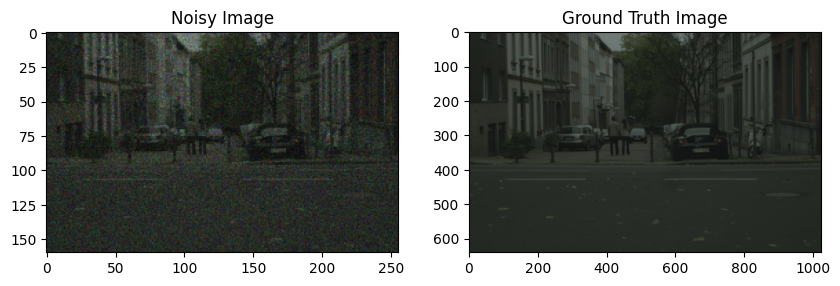

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(noisy_img)
plt.title("Noisy Image")

plt.subplot(1, 2, 2)
plt.imshow(clean_img)
plt.title("Ground Truth Image")

plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform_noisy = T.Compose([
    T.Resize((256, 160)),   # Low-res input
    T.ToTensor()
])

transform_clean = T.Compose([
    T.Resize((1024, 640)),  # High-res target
    T.ToTensor()
])
train_dataset = LowLightSRDataset(
    noisy_dir="/kaggle/input/dlp-jan-2025-nppe-3/archive/train/train",
    clean_dir="/kaggle/input/dlp-jan-2025-nppe-3/archive/train/gt",
    transform_noisy=transform_noisy,
    transform_clean=transform_clean
)

val_dataset = LowLightSRDataset(
    noisy_dir="/kaggle/input/dlp-jan-2025-nppe-3/archive/val/val",
    clean_dir="/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt",
    transform_noisy=transform_noisy,
    transform_clean=transform_clean
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [7]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.l1 = nn.L1Loss()

    def forward(self, sr, hr):
        return self.l1(self.vgg(sr), self.vgg(hr))

# Residual Block with Scaling
class ResidualBlock(nn.Module):
    def __init__(self, channels, scale=0.1):
        super().__init__()
        self.scale = scale
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.scale * self.block(x)

# Enhanced Super-Resolution Network (EDSR-inspired)
class SuperResolutionNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_features=128, num_res_blocks=16):
        super().__init__()
        self.initial = nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)

        self.res_blocks = nn.Sequential(*[
            ResidualBlock(num_features) for _ in range(num_res_blocks)
        ])

        self.mid_conv = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)

        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        initial_feat = self.initial(x)
        x = self.res_blocks(initial_feat)
        x = self.mid_conv(x) + initial_feat  # Long skip connection
        x = self.upsample(x)
        x = self.output(x)
        return x


In [8]:
def calculate_psnr(pred, target):
    mse = nn.functional.mse_loss(pred, target)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def train_model(model, train_loader, val_loader, device, epochs=15, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    pixel_criterion = nn.L1Loss()
    perceptual_criterion = PerceptualLoss().to(device)

    best_psnr = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for noisy, clean in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            loss = pixel_criterion(output, clean) + 0.01 * perceptual_criterion(output, clean)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        scheduler.step()

        # Validation
        model.eval()
        val_psnr = 0
        with torch.no_grad():
            for noisy, clean in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                noisy, clean = noisy.to(device), clean.to(device)
                output = model(noisy)
                val_psnr += calculate_psnr(output, clean).item()
        avg_val_psnr = val_psnr / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val PSNR: {avg_val_psnr:.2f}")

        if avg_val_psnr > best_psnr:
            best_psnr = avg_val_psnr
            torch.save(model.state_dict(), "best_model.pth")
            print("New best model saved!")

In [9]:
model = SuperResolutionNet().to(device)
train_model(model, train_loader, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 227MB/s] 
Epoch 1/15 [Val]: 100%|██████████| 67/67 [00:58<00:00,  1.15it/s]


Epoch [1/15] - Train Loss: 0.0208, Val PSNR: 36.48
New best model saved!


Epoch 2/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.23it/s]


Epoch [2/15] - Train Loss: 0.0127, Val PSNR: 37.58
New best model saved!


Epoch 3/15 [Val]: 100%|██████████| 67/67 [00:53<00:00,  1.24it/s]


Epoch [3/15] - Train Loss: 0.0119, Val PSNR: 38.00
New best model saved!


Epoch 4/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.24it/s]


Epoch [4/15] - Train Loss: 0.0116, Val PSNR: 38.08
New best model saved!


Epoch 5/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.24it/s]


Epoch [5/15] - Train Loss: 0.0114, Val PSNR: 38.41
New best model saved!


Epoch 6/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.22it/s]


Epoch [6/15] - Train Loss: 0.0112, Val PSNR: 38.50
New best model saved!


Epoch 7/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.22it/s]


Epoch [7/15] - Train Loss: 0.0111, Val PSNR: 38.44


Epoch 8/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.24it/s]


Epoch [8/15] - Train Loss: 0.0110, Val PSNR: 38.45


Epoch 9/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.23it/s]


Epoch [9/15] - Train Loss: 0.0109, Val PSNR: 38.52
New best model saved!


Epoch 10/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.23it/s]


Epoch [10/15] - Train Loss: 0.0109, Val PSNR: 38.59
New best model saved!


Epoch 11/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.22it/s]


Epoch [11/15] - Train Loss: 0.0108, Val PSNR: 38.56


Epoch 12/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.24it/s]


Epoch [12/15] - Train Loss: 0.0108, Val PSNR: 38.62
New best model saved!


Epoch 13/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.23it/s]


Epoch [13/15] - Train Loss: 0.0107, Val PSNR: 38.64
New best model saved!


Epoch 14/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.23it/s]


Epoch [14/15] - Train Loss: 0.0107, Val PSNR: 38.61


Epoch 15/15 [Val]: 100%|██████████| 67/67 [00:54<00:00,  1.23it/s]

Epoch [15/15] - Train Loss: 0.0107, Val PSNR: 38.67
New best model saved!


In [12]:
model.load_state_dict(torch.load('/kaggle/input/img_sr/pytorch/default/1/best_model (1).pth', map_location=device))
model.eval()

<ipython-input-12-4476f4e991b0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/img_sr/pytorch/default/1/best_model (1).pth'

SuperResolutionNet(
  (initial): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [10]:
test_dir = '/kaggle/input/dlp-jan-2025-nppe-3/archive/test'
output_dir = '/kaggle/working/test_predictions' 
os.makedirs(output_dir, exist_ok=True)

In [11]:
transform = T.ToTensor()
to_pil = T.ToPILImage()

# --- Inference Loop ---
test_images = sorted(os.listdir(test_dir))
for filename in tqdm(test_images, desc="Running inference on test set"):
    img_path = os.path.join(test_dir, filename)
    img = Image.open(img_path).convert("RGB")

    input_tensor = transform(img).unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        output_tensor = model(input_tensor).squeeze(0).cpu().clamp(0, 1)

    output_img = to_pil(output_tensor)
    output_img.save(os.path.join(output_dir, filename))  # Save with same name

print("✅ All predictions saved. Ready for submission CSV.")

Running inference on test set: 100%|██████████| 60/60 [00:29<00:00,  2.06it/s]

✅ All predictions saved. Ready for submission CSV.


In [12]:

import numpy as np
import pandas as pd


def images_to_csv(folder_path, output_csv):
    data_rows = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L') 
            image_array = np.array(image).flatten()[::8]
            # Replace 'test_' with 'gt_' in the ID
            image_id = filename.split('.')[0].replace('test_', 'gt_')
            data_rows.append([image_id, *image_array])
    column_names = ['ID'] + [f'pixel_{i}' for i in range(len(data_rows[0]) - 1)]
    df = pd.DataFrame(data_rows, columns=column_names)
    df.to_csv(output_csv, index=False)
    print(f'Successfully saved to {output_csv}')

folder_path = '/kaggle/working/test_predictions'
output_csv = 'submission.csv'
images_to_csv(folder_path, output_csv)

Successfully saved to submission.csv


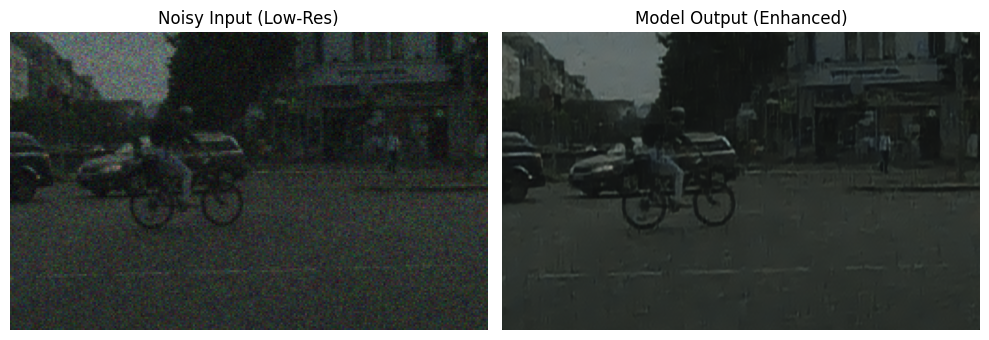

In [13]:
test_image_path = '/kaggle/input/dlp-jan-2025-nppe-3/archive/test/test_00004.png'  
pred_image_path = '/kaggle/working/test_predictions/test_00004.png'

input_img = Image.open(test_image_path).convert("RGB")
pred_img = Image.open(pred_image_path).convert("RGB")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Noisy Input (Low-Res)")
plt.imshow(input_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Model Output (Enhanced)")
plt.imshow(pred_img)
plt.axis('off')

plt.tight_layout()
plt.show()